In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


import sys
sys.path.append('/home/hudson/Projects/Tensorflow-GAN')
from lib.utils import log_progress

In [2]:
def entropy(pk):
    return -tf.reduce_sum(pk*tf.log(pk))

In [3]:
def make_gen(n_input = 100, n_classes = 2, n_hidden_1 = 300, n_hidden_2 = 300, n_out = 2,
             random_seed = None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    gen_params = {}
    gen_params['n_classes'] = n_classes
    gen_params['n_input'] = n_input
    gen_params['n_hidden_1'] = n_hidden_1 # 1st layer number of features
    gen_params['n_hidden_2'] = n_hidden_2 # 2nd layer number of features
    gen_params['n_out'] = n_out

    # Store layers weight & bias
    gen_params['weights'] = {
        'w1': tf.Variable(xavier_init([n_input+n_classes, n_hidden_1]), name = 'g_w1'),
        'w2': tf.Variable(xavier_init([n_hidden_1, n_hidden_2]), name = 'g_w2'),
        'w_out': tf.Variable(xavier_init([n_hidden_2, n_out]), name = 'g_w_out')
    }
    gen_params['biases'] = {
        'b1': tf.Variable(xavier_init([n_hidden_1]), name = 'g_b1'),
        'b2': tf.Variable(xavier_init([n_hidden_2]), name = 'g_b1'),
        'b_out': tf.Variable(xavier_init([n_out]), name = 'g_b_out')
    }
    
    #return parameter dict
    return(gen_params)

def make_disc(n_input = 2, n_hidden_1 = 300, n_hidden_2 = 300, n_classes=2,
             random_seed = None):
    #Initializer
    xavier_init = xavier_initializer(seed = random_seed)
    
    # Network Parameters
    disc_params = {}
    disc_params['n_input'] = n_input
    disc_params['n_hidden_1'] = n_hidden_1 # 1st layer number of features
    disc_params['n_hidden_2'] = n_hidden_2 # 2nd layer number of features
    disc_params['n_classes'] = n_classes

    # Store layers weight & bias
    disc_params['weights'] = {
        'w1': tf.Variable(xavier_init([n_input, n_hidden_1]), name = 'd_w1'),
        'w2': tf.Variable(xavier_init([n_hidden_1, n_hidden_2]), name = 'd_w2'),
        'w_out': tf.Variable(xavier_init([n_hidden_2, n_classes]), name = 'd_w_out')
    }
    disc_params['biases'] = {
        'b1': tf.Variable(xavier_init([n_hidden_1]), name = 'd_b1'),
        'b2': tf.Variable(xavier_init([n_hidden_2]), name = 'd_b1'),
        'b_out': tf.Variable(xavier_init([n_classes]), name = 'd_b_out')
    }
    
    #return parameter dict
    return(disc_params)

In [4]:
class GAN(object):
    def __init__(self, gen_params = None, disc_params = None,
                 random_seed = None):
        
        #Generator params, may pass optional initialization
        gen_params = gen_params if gen_params is not None else make_gen(random_seed = random_seed)
        self.gen_params = gen_params
        
        z_dim = gen_params['n_input']
        self.z_dim = z_dim
        g_theta = [theta for theta in gen_params['weights'].values()] + \
                  [theta for theta in gen_params['biases'].values()]
        self.g_theta = g_theta
            
        #Discriminator params, may pass optional initialization
        disc_params = disc_params if disc_params is not None else make_disc(random_seed = random_seed)
        self.disc_params = disc_params
        
        x_dim = disc_params['n_input']
        d_theta = [theta for theta in disc_params['weights'].values()] + \
                  [theta for theta in disc_params['biases'].values()]
        self.d_theta = d_theta
            
        #GAN graph
        X = tf.placeholder(tf.float32, shape=[None, x_dim], name='X')
        self.X = X
        Z = tf.placeholder(tf.float32, shape=[None, z_dim], name='Z')
        self.Z = Z
        I = tf.placeholder(tf.float32, shape=[None, gen_params['n_classes']], name='I')
        self.I = I
        
        G_X = self.gen(Z, I)
        
        D_logit_real, D_real = self.disc(X)
        self.D_logit_real = D_logit_real
        self.D_real = D_real
        
        D_logit_fake, D_fake = self.disc(G_X)
        self.D_logit_fake = D_logit_fake
        self.D_fake = D_fake
        
        #Session
        sess = tf.Session()
        self.sess = sess
        
        # Initializing the variables
        init = tf.global_variables_initializer()
        with sess.as_default():
            sess.run(init)
        self.initialized=set(tf.global_variables())
        

    #Generator and discriminator models
    def gen(self, z, i):
        input_vec = tf.concat((z, i), 1)
        
        #Params
        weights = self.gen_params['weights']
        biases = self.gen_params['biases']
        
        #Graph
        g_h1 = tf.nn.relu(tf.matmul(input_vec, weights['w1']) + biases['b1'])
        g_h2 = tf.nn.relu(tf.matmul(g_h1, weights['w2']) + biases['b2'])
        # Output layer with linear activation
        g_out = tf.matmul(g_h2, weights['w_out']) + biases['b_out']
        
        return(g_out)
    
    def disc(self, x):
        #Params
        weights = self.disc_params['weights']
        biases = self.disc_params['biases']
        
        #Graph
        d_h1 = tf.nn.relu(tf.matmul(x, weights['w1']) + biases['b1'])
        d_h2 = tf.nn.relu(tf.matmul(d_h1, weights['w2']) + biases['b2'])
        # Logit
        d_logit = tf.matmul(d_h2, weights['w_out']) + biases['b_out']
        #Probability
        d_prob = tf.nn.softmax(d_logit)
        
        return(d_logit, d_prob)
    
    def sample_Z(self, m):
        return np.random.uniform(-1., 1., size=[m, self.z_dim]).astype('float32')
    
    def sample_G(self, m, i):
        return self.gen(self.sample_Z(m), i)
    
    def train(self, x, lamb = .1, learning_rate = 0.001, training_epochs = 300, mb_size = 64, display_step = 30):
        sess = self.sess
        
        N = len(x)
        n_batches = N // mb_size
        
        #Losses
        D_loss = (
            tf.reduce_mean(tf.map_fn(entropy, self.D_real))     #Certain of class assignments for real samples
            - entropy(tf.reduce_mean(self.D_real, 0))           #Use all classes equally
            - tf.reduce_mean(tf.map_fn(entropy, self.D_fake))   #Uncertain of class assignments for fake samples
        )
        
        G_loss = (
            tf.reduce_mean(tf.map_fn(entropy, self.D_fake))     #Certain of class assignments for fake samples
            - entropy(tf.reduce_mean(self.D_fake, 0))           #Use all classes equally
                                                                #Separate gen representations of classes
            + lamb * tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.I, logits=self.D_logit_fake))
        )
        
        #Optimizers
        D_solver = tf.train.RMSPropOptimizer(learning_rate = learning_rate).minimize(D_loss, var_list=self.d_theta)
        G_solver = tf.train.RMSPropOptimizer(learning_rate = learning_rate).minimize(G_loss, var_list=self.g_theta)
        
        #Training initialization
        init_train = tf.variables_initializer(set(tf.global_variables()) - self.initialized)
        
        with sess.as_default():
            sess.run(init_train)
            self.initialized=set(tf.global_variables())
            
            D_losses = []
            G_losses = []
            for epoch in log_progress(range(training_epochs), every = 1, name='Epoch'):
                try:
                    D_loss_avg = 0
                    G_loss_avg = 0
                    if epoch % display_step == 0:

                        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
                        
                        i = np.zeros((1000*self.gen_params['n_classes'], self.gen_params['n_classes'])).astype('float32')
                        for j in range(self.gen_params['n_classes']):
                            i[j*1000:(j+1)*1000,j] = 1
                        G_x = self.sample_G(self.gen_params['n_classes']*1000,i)

                        ax1.scatter(x[:,0], x[:,1])
                        ax1.scatter(G_x[:,0].eval(), G_x[:,1].eval(), color=['red' if ij[0] == 1 else 'blue' for ij in i])

                        ax2.plot(D_losses, label = "D_loss")
                        ax2.plot(G_losses, label = "G_loss")
                        ax2.set_title("Loss")
                        ax2.set_xlabel("Epoch")
                        ax2.set_ylabel("Loss")
                        ax2.legend()
                        
                        plt.show()

                    for batch in range(n_batches):
                        X_mb = x[(batch*mb_size):((batch+1)*mb_size), :]

                        nk = mb_size * self.gen_params['n_classes']
                        for j in range(self.gen_params['n_classes']):
                            i = np.zeros((nk, self.gen_params['n_classes'])).astype('float32')
                            i[j*mb_size:(j+1)*mb_size,j] = 1
                        
                        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={self.X: X_mb, self.Z: self.sample_Z(nk), self.I:i})
                        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={self.Z: self.sample_Z(nk), self.I:i})

                        D_loss_avg = D_loss_avg + D_loss_curr/n_batches
                        G_loss_avg = G_loss_avg + G_loss_curr/n_batches
                    D_losses.append(D_loss_avg)
                    G_losses.append(G_loss_avg)
                except KeyboardInterrupt:
                    plt.figure()
                    plt.plot(D_losses, label = "D_loss")
                    plt.plot(G_losses, label = "G_loss")
                    plt.title("Loss")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.legend()
                    raise
            
            plt.figure()
            plt.plot(D_losses, label = "D_loss")
            plt.plot(G_losses, label = "G_loss")
            plt.title("Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

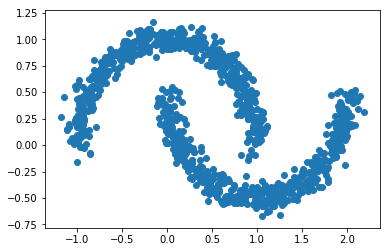

In [5]:
from sklearn.datasets import make_moons
N = 1000
X, Y = make_moons(N, noise = .07)
X = X.astype('float32')
Y = np.array([[1,0] if y else [0,1] for y in Y])
Y = Y.astype('float32')

plt.scatter(X[:,0], X[:,1])

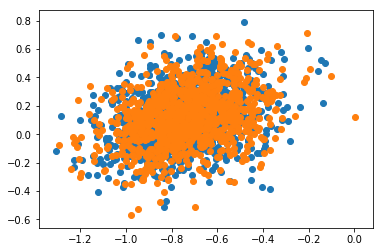

In [6]:
gan = GAN()

N = 1000
i1 = np.tile(np.array([1,0], dtype = 'float32'), (N,1))
i2 = np.tile(np.array([0,1], dtype = 'float32'), (N,1))

g1 = gan.sample_G(N, i1).eval(session=gan.sess)
g2 = gan.sample_G(N, i2).eval(session=gan.sess)
plt.scatter(g1[:,0], g1[:,1])
plt.scatter(g2[:,0], g2[:,1])

Widget Javascript not detected.  It may not be installed or enabled properly.


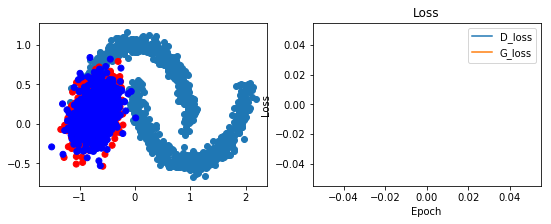

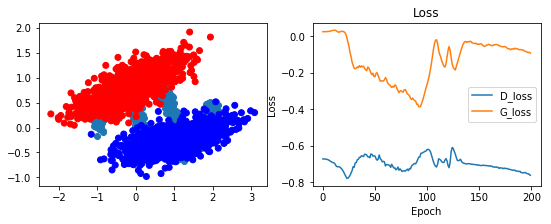

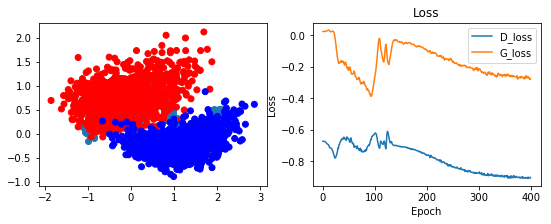

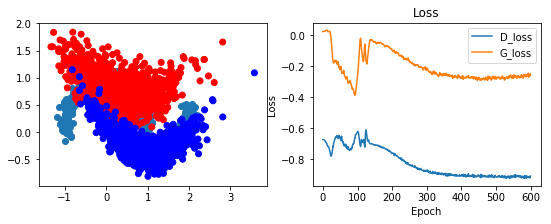

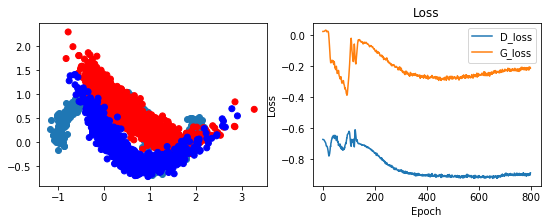

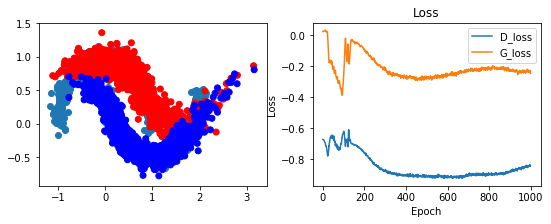

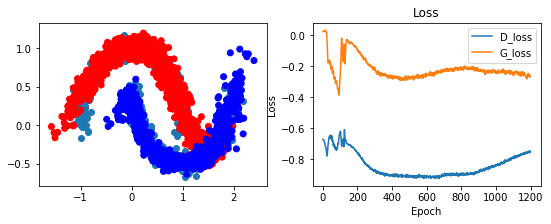

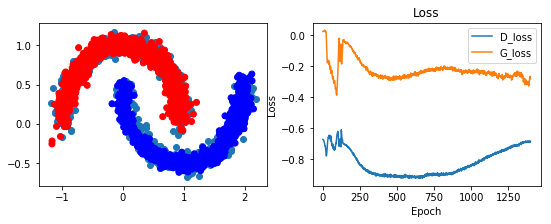

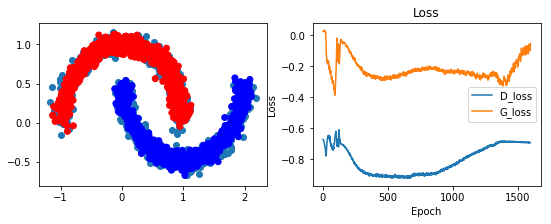

KeyboardInterrupt: 

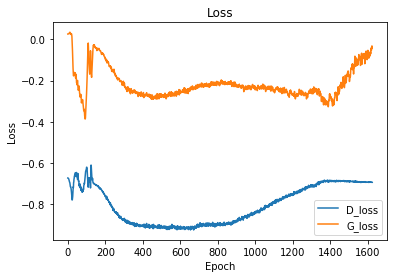

In [7]:
gan.train(X, learning_rate = .00005, training_epochs = 2000, display_step = 200, mb_size = 64)

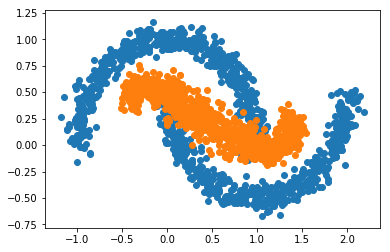

In [8]:
n = 1000
gX = gan.sample_G(n, np.tile([.5,.5], n).reshape(n, -1).astype('float32')).eval(session = gan.sess)
plt.scatter(X[:,0], X[:,1])
plt.scatter(gX[:,0], gX[:,1])

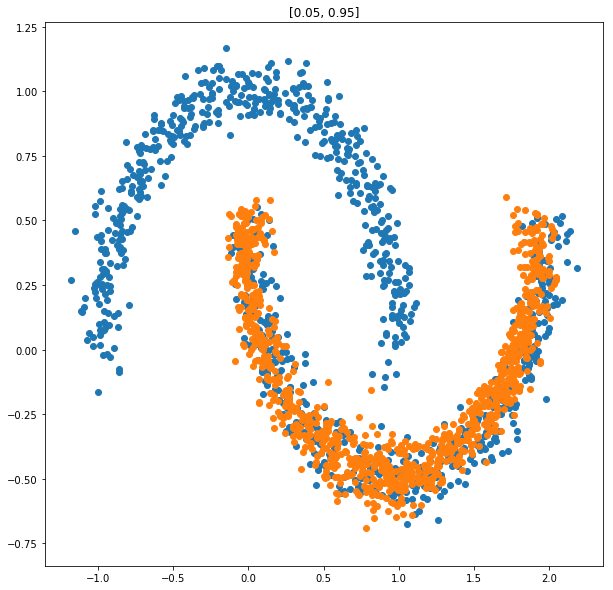

In [41]:
from matplotlib import animation, rc
rc('animation', html='html5')


fig, ax = plt.subplots(figsize=(10,10))
n = 1000

ax.scatter(X[:,0], X[:,1])
gX = gan.sample_G(n, np.tile([0,1], n).reshape(n, -1).astype('float32')).eval(session = gan.sess)
sc = ax.scatter(gX[:,0], gX[:,1])

dt = .05
T = int(1/dt)

# animation function. This is called sequentially
def animate(i):
    if i > T: i = 2*T - i
    n = 1000
    gX = gan.sample_G(n, np.tile([0+i*dt,1-i*dt], n).reshape(n, -1).astype('float32')).eval(session = gan.sess)
    sc.set_offsets(gX)
    ax.set_title("[%.2f, %.2f]" %(0+i*dt,1-i*dt))
    return (sc,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=2*T, interval=100, blit=True)


rc('animation', html='html5')

anim